# Imports:

In [104]:
# system & general:
from os import listdir, mkdir, makedirs
from os.path import isfile, join, isdir, exists
import cPickle as pickle
import os
import re
import time

# data analysis and statistics:
import pandas as pd
import numpy as np
from scipy import stats
import random
from scipy.stats import pearsonr, fisher_exact
import math
from scipy.spatial.distance import braycurtis, pdist, euclidean
# figures:
import matplotlib as mpl
# mpl.use('Agg')

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns 
from matplotlib.ticker import FormatStrFormatter
from matplotlib import gridspec
# from PNPChip.ForPaper.Figures.nature_guidline_utils import m2inch
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# my functions:
from ShaniBA.myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot, adjusted_roundup
from ShaniBA.MyFunctionsShani import *
from ShaniBA.GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from ShaniBA.TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from ShaniBA.TCR_microbiome_interactions.TCR_microbiome_interactions_functions2 import *
from ShaniBA.SampleLists.SampleFileFunctions import *
from ShaniBA.PhenotypicData.PhenotypeGenerationFunctions import *
from ShaniBA.CardioProject.CardioFunctions import *
from ShaniBA.PredictionPipeline.PredictionFunctions import *
from ShaniBA.TCR_feature_generation.SubsamplingFunctions import *
from ShaniBA.CardioProject.Figures.GeneralFigureFunctions import *
from ShaniBA.myplots import *

# definitions:

In [135]:
#####path definitions:
MyPath = '/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530', 'rb') as fp:
    PNP530 = pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126', 'rb') as fp:
    Cardio126 = pickle.load(fp)
PNP530Cardio126 = PNP530 + Cardio126

FIG1_DIR = '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Presentations and Manuscripts/CardioTCR paper/FigureDraft_april19/\
Fig1_phenotypePrediction/'
PRED_RESULTS_DIR = '/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/'

##### general definitions:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 1000)
np.set_printoptions(precision=4, linewidth=200)

cdate = str(time.strftime("%d%m%Y"))
cdate

'14042019'

# general setting:

3x3 : PREDICTION IN HEALTHY, PREDICTION IN PATIENTS, PREDICTION ACCURACY COMPARISON:

# FUNCTIONS:

In [105]:
def set_fig1_definitions():
    params = {
   'axes.labelsize': 16,
   'font.size': 12,
   'legend.fontsize': 8,
   'xtick.labelsize': 14,
   'ytick.labelsize': 14,
   'text.usetex': False,
#    'figure.figsize': [m2inch(183), m2inch(247)],#[4.5, 4.5]
   'figure.dpi': 300,
   'xtick.direction':'out'}


    mpl.rcParams.update(params)
    mpl.rcParams['axes.linewidth'] = 0.5
    mpl.rcParams['axes.edgecolor'] = 'black'
    mpl.rcParams['axes.facecolor'] = 'white'
    mpl.rcParams['xtick.direction'] = 'out'
    mpl.rcParams['xtick.minor.pad'] = 4

    return

In [106]:
def get_real_and_pred_data(phen, real_data_path, pred_data_file,patients_also=True):   
        
    ## get predicted and real data for healthy:
    real_data=pd.read_excel(real_data_path).set_index('BD')[phen].dropna()
    pred_data_PNP530=pd.read_pickle(pred_data_file)[phen].dropna()

    #merge for healthy:
    pred_and_real_PNP530=pd.merge(pd.DataFrame(real_data.rename(phen)),pd.DataFrame(pred_data_PNP530.rename('pred '+phen).astype(float)),how='inner',left_index=True,right_index=True)
    print ('pred_and_real_PNP530.shape: ',pred_and_real_PNP530.shape)
    print pred_and_real_PNP530.head()
    
    if patients_also:
        ### get predicted and real data for patients:
        pred_and_real_Cardio126=pd.read_pickle(PRED_RESULTS_DIR+'Cardio126_phens_basedOnHealthy/pred_and_real_%s.pkl' %phen)[['average pred',phen]]
        pred_and_real_Cardio126=pred_and_real_Cardio126.rename(columns={'average pred':'pred '+phen})
        print ('pred_and_real_Cardio126: ',pred_and_real_Cardio126.shape)
        pred_and_real_Cardio126.head()
    else:
        pred_and_real_Cardio126=None
    
    return pred_and_real_PNP530, pred_and_real_Cardio126
        

In [115]:
def plot_phen_prediction_ROC_PR_fig1(ax,phen,pred_and_real):
    
    y=pd.DataFrame(pred_and_real[phen])
    y_pred_df=pd.DataFrame(pred_and_real['pred '+phen].rename('pred_proba'))
    # #plot:
    pos_label = 1
    ax, inset_axes,roc_auc, pr_auc, prevalence = plot_ROC_PR_AUC(y, y_pred_df,ax,color1='darkred', color2='grey', ticklabelsize=mpl.rcParams['xtick.labelsize'],
                                      textsize=mpl.rcParams['font.size'], labelsize=mpl.rcParams['axes.labelsize'], add_texts=False)
    ax.annotate('ROC AUC=%s\nPR AUC=%s' % (round(roc_auc, 3), round(pr_auc, 2)), xy=(0.04, 0.98), xycoords='axes fraction',
                 fontsize=mpl.rcParams['font.size'], xytext=(0, 0), textcoords='offset points', fontweight='bold', ha='left', va='top')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    inset_axes.text(0.01,prevalence-0.01,'Prevalence=%s' %prevalence,transform=inset_axes.transAxes,ha='left',va='top',
                    fontsize=mpl.rcParams['font.size']-2)
    
    return ax


def plot_phen_prediction_correlation_fig1(ax,phen,pred_and_real,outlierSTD=None,toAnnotate=True):
    
    merged = pred_and_real.rename(columns={phen:'Real','pred '+phen:'Predicted'}).dropna(how='any')
    print ('merged.head(): ',merged.head())

    # # plot data:
    x = 'Real'; y = 'Predicted'
    if outlierSTD is not None:
        x_lim1=merged[x].mean()-outlierSTD * merged[x].std()
        x_lim2=merged[x].mean()+outlierSTD * merged[x].std()
        print ('value limits are: ',x_lim1,x_lim2)
        print ('merged.shape before outlier removal= ',merged.shape)
        merged=merged[(merged[x]>x_lim1) & (merged[x]<x_lim2)]
        print ('merged.shape after outlier removal= ',merged.shape)
        
    merged.plot(x, y, ax=ax, kind='scatter', alpha=0.5, c='darkred', s=60)
    ax.plot(np.unique(merged[x]), np.poly1d(np.polyfit(merged[x], merged[y], 1))(np.unique(merged[x])), c='black', linewidth=1)
    r, p = MyPearsonr(merged[x], merged[y])
    print r, p
    if toAnnotate:
        ax.annotate('r=%s\np=%.1E' % (round(r, 2), p), xy=(0.04, 0.98), xycoords='axes fraction', fontsize=mpl.rcParams['font.size'],
                        xytext=(0, 0), textcoords='offset points', fontweight='bold',
                        ha='left', va='top')   
    return ax,r,p




In [116]:
def compare_healthy_patients_predictions_grouped(phen,real_data_path,pred_data_file,bin_edges,bin_names,ax=None,isBinary=False):
    
    if isBinary:
        bin_edges=[-1,0,1]
    
    ## get predicted and real data for healthy:

    real_data=pd.read_excel(real_data_path).set_index('BD')[phen].dropna()

    pred_data_PNP530=pd.read_pickle(pred_data_file)[phen].dropna()


    #merge for healthy:
    pred_and_real_PNP530=pd.merge(pd.DataFrame(real_data.rename(phen)),pd.DataFrame(pred_data_PNP530.rename('pred '+phen).astype(float)),how='inner',left_index=True,right_index=True)
    print ('pred_and_real_PNP530.shape: ',pred_and_real_PNP530.shape)
    print pred_and_real_PNP530.head()

    ### get predicted and real data for patients:
    pred_and_real_Cardio126=pd.read_pickle(PRED_RESULTS_DIR+'Cardio126_phens_basedOnHealthy/pred_and_real_%s.pkl' %phen)[['average pred',phen]]
    pred_and_real_Cardio126=pred_and_real_Cardio126.rename(columns={'average pred':'pred '+phen})
    print ('pred_and_real_Cardio126: ',pred_and_real_Cardio126.shape)
    pred_and_real_Cardio126.head()
    
    ##plot:
    if ax is None:
        fig,ax=plt.subplots(figsize=(5,5))


    values_dict={}

    for item in [('Healthy',pred_and_real_PNP530,'grey','lightgrey'),('Patients',pred_and_real_Cardio126,'darkred','red')]:
        df=item[1]
        df_name=item[0]
        color_real=item[2]
        color_pred=item[3]

    #     print df.columns.tolist()
        if isBinary:
            fig_range=range(2)
        else:
            fig_range=range(1,len(bin_edges))
        
#         print df_name
#         print 'df[phen]:'
#         print df[phen]

        df['Binned '+phen]=pd.cut(df[phen],bin_edges,labels=fig_range)
        grouped=df.groupby('Binned '+phen).agg([np.mean,np.std,np.size])
        grouped.columns = [' '.join(col).strip() for col in grouped.columns.values]

        for n in fig_range:
            values_dict[df_name+str(n)]=df[(df[phen]>=bin_edges[n-1]) & (df[phen]<bin_edges[n])]['pred '+phen].tolist()

        print df_name
        print grouped
        
        if not isBinary:
            ax.errorbar(fig_range,grouped[phen+ ' mean'],yerr=grouped[phen+ ' std'], fmt='_',color=color_real,alpha=1,linewidth=3,markersize=20,
                    label=df_name+' (real)')
        ax.errorbar(fig_range,grouped['pred '+phen+' mean'],yerr=grouped['pred '+phen+' std'], fmt='o',color=color_pred,alpha=0.5,linewidth=4,markersize=8,
                   label=df_name+' (pred.)')
        ax.set_xticks(fig_range)
        ax.set_xticklabels(bin_names,rotation=45,fontsize='medium')
    min_values=[]; max_values=[]
    for n in fig_range:
        data1=values_dict['Healthy'+str(n)]
        data2=values_dict['Patients'+str(n)]
#         min_values.append(np.min(data1+data2))
#         max_values.append(np.max(data1+data2))
        MW_s, MW_p=mannwhitneyu(data1,data2)
        print ('MW test: %s bin ' %phen,bin_names[n-1],MW_s, MW_p)

        t_s, t_p=ttest_ind(data1,data2)
        print ('t test: %s bin ' %phen,bin_names[n-1],t_s, t_p)
        print ''

        ax.legend(loc='upper left')
        ax.set_ylabel(phen+ '',fontsize='large')
        ax.set_xlabel(phen+ ' Group',fontsize='large')

#     ymin=adjusted_rounddown(np.min(min_values))
#     ymax=adjusted_roundup(np.min(max_values))
      
        
    xmin=fig_range[0]-0.5; xmax=fig_range[-1]+0.5
    
    ax.set_xlim(xmin,xmax)
#     ax.set_ylim(ymin,ymax)

    return ax
    
    

# plot figure:

In [117]:
plt.show()

('pred_and_real_PNP530.shape: ', (527, 2))
        Age   pred Age
BD                    
BD406  65.0  40.083622
BD228  32.0  33.693031
BD714  39.0  39.104591
BD808  26.0  31.499493
BD144  36.0  37.083290
('pred_and_real_Cardio126: ', (126, 2))
('pred_and_real_PNP530.shape: ', (530, 2))
       Gender_Male  pred Gender_Male
BD                                  
BD406            0          0.570134
BD228            1          0.360548
BD714            1          0.601114
BD808            0          0.524875
BD144            0          0.344421
('pred_and_real_Cardio126: ', (126, 2))
('pred_and_real_PNP530.shape: ', (504, 2))
       HbA1C  pred HbA1C
BD                      
BD406   6.40    5.461933
BD228   5.10    5.427275
BD714   5.31    5.390162
BD808   5.18    5.265903
BD144   5.10    5.449624
('pred_and_real_Cardio126: ', (126, 2))
Age
('merged.head(): ',        Real  Predicted
BD                    
BD406  65.0  40.083622
BD228  32.0  33.693031
BD714  39.0  39.104591
BD808  26.0  31.4

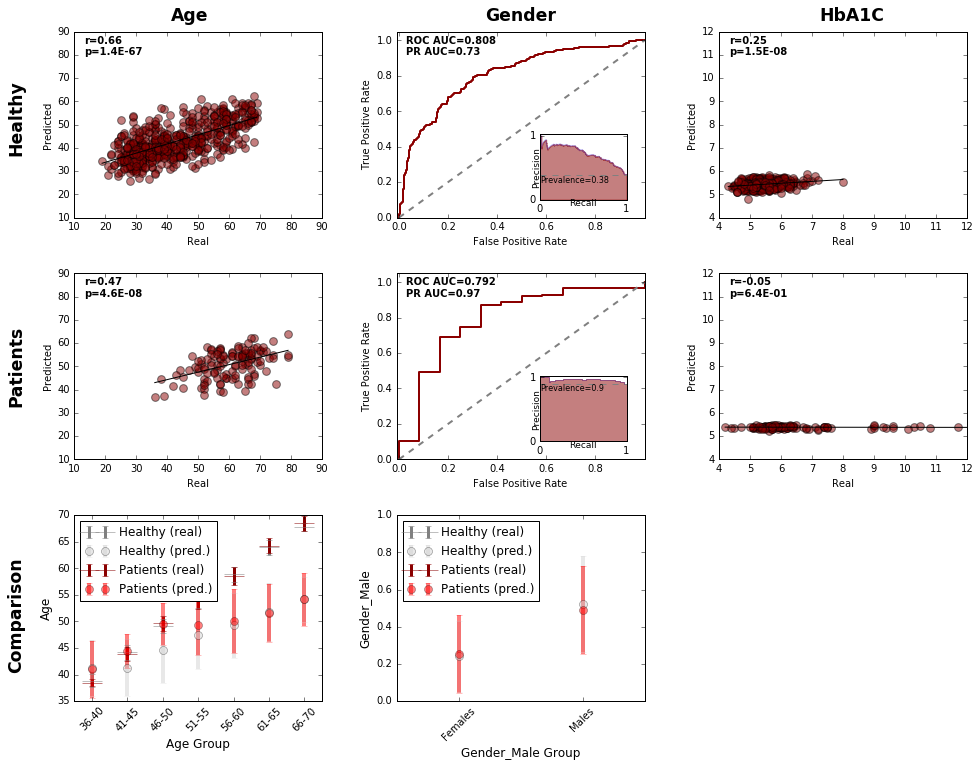

now saving
saved


In [138]:
fig = plt.figure(figsize=(16, 12))
gs0 = gridspec.GridSpec(3, 3, wspace=0.3, hspace=0.3)

ax=plt.gca()

x1=(1./3 - 0.3/4)/2
x2=0.5
x3=1-x1

plt.text(x1,1.01,'Age',ha='center',va='bottom',fontsize='xx-large',fontweight='bold',transform=ax.transAxes)
plt.text(x2,1.01,'Gender',ha='center',va='bottom',fontsize='xx-large',fontweight='bold',transform=ax.transAxes)
plt.text(x3,1.01,'HbA1C',ha='center',va='bottom',fontsize='xx-large',fontweight='bold',transform=ax.transAxes)

plt.text(-0.075,x3,'Healthy',ha='left',va='center',fontsize='xx-large',fontweight='bold',transform=ax.transAxes,rotation=90)
plt.text(-0.075,x2,'Patients',ha='left',va='center',fontsize='xx-large',fontweight='bold',transform=ax.transAxes,rotation=90)
plt.text(-0.075,x1,'Comparison',ha='left',va='center',fontsize='xx-large',fontweight='bold',transform=ax.transAxes,rotation=90)

remove_spines(removeFigBorders=True)



real_data_path='/net/mraid08/export/jafar/Microbiome/Analyses/TCR/phenotypes_byBD/\
PNP530Cardio126_Age_Gender_Male_HbA1C_SmokingStatus_Yes_BMI_HDL_Smoking_ever.xlsx'
pred_data_file=PRED_RESULTS_DIR+'PNP530_majorPhenotypes/\
AgeGenderBMIHbA1CSmokingCholesterol_XGB_randomSearch_25_TCRfeatures_optByExpVar/predictions_df.pkl'

pred_and_real_PNP530_age, pred_and_real_Cardio126_age=get_real_and_pred_data('Age', real_data_path, pred_data_file,patients_also=True)
pred_and_real_PNP530_gender, pred_and_real_Cardio126_gender=get_real_and_pred_data('Gender_Male', real_data_path, pred_data_file,patients_also=True)
pred_and_real_PNP530_HbA1C, pred_and_real_Cardio126_HbA1C=get_real_and_pred_data('HbA1C', real_data_path, pred_data_file,patients_also=True)


### A:
ax1 = plt.Subplot(fig, gs0[0, 0])
fig.add_subplot(ax1)

ax2 = plt.Subplot(fig, gs0[0, 1])
fig.add_subplot(ax2)

ax3 = plt.Subplot(fig, gs0[0, 2])
fig.add_subplot(ax3)

ax4 = plt.Subplot(fig, gs0[1, 0])
fig.add_subplot(ax4)

### B:
ax5 = plt.Subplot(fig, gs0[1, 1])
fig.add_subplot(ax5)

ax6 = plt.Subplot(fig, gs0[1, 2])
fig.add_subplot(ax6)

ax7 = plt.Subplot(fig, gs0[2, 0])
fig.add_subplot(ax7)

ax8 = plt.Subplot(fig, gs0[2, 1])
fig.add_subplot(ax8)

# plot correlations for healthy predictions - Age, HbA1C:
phen_list=('Age','HbA1C')
ax_healthy_list=[ax1,ax3]
ax_patient_list=[ax4,ax6]
pred_and_real_healthy_list=[pred_and_real_PNP530_age,pred_and_real_PNP530_HbA1C]
pred_and_real_patient_list=[pred_and_real_Cardio126_age,pred_and_real_Cardio126_HbA1C]
min_val_Age=adjusted_rounddown(np.min([pred_and_real_PNP530_age.min()*0.98,pred_and_real_Cardio126_age.min()*0.98]))
max_val_Age=adjusted_roundup(np.max([pred_and_real_PNP530_age.max()*1.02,pred_and_real_Cardio126_age.max()*1.02]))
min_val_HbA1C=adjusted_rounddown(np.min([pred_and_real_PNP530_HbA1C.min()*0.98,pred_and_real_Cardio126_HbA1C.min()*0.98]))
max_val_HbA1C=adjusted_roundup(np.max([pred_and_real_PNP530_HbA1C.max()*1.02,pred_and_real_Cardio126_HbA1C.max()*1.02]))

for n in range(2):
    phen=phen_list[n]
    print phen
    pred_and_real_healthy=pred_and_real_healthy_list[n]
    pred_and_real_patient=pred_and_real_patient_list[n]
    ax_healthy=ax_healthy_list[n]
    ax_patient=ax_patient_list[n]
    

    ax_healthy,r,p=plot_phen_prediction_correlation_fig1(ax_healthy,phen,pred_and_real_healthy,outlierSTD=None,toAnnotate=True)
    ax_patient,r,p=plot_phen_prediction_correlation_fig1(ax_patient,phen,pred_and_real_patient,outlierSTD=None,toAnnotate=True)

    if n==0:
        ax_healthy.set_xlim(min_val_Age,max_val_Age)
        ax_healthy.set_ylim(min_val_Age,max_val_Age)
        ax_patient.set_xlim(min_val_Age,max_val_Age)
        ax_patient.set_ylim(min_val_Age,max_val_Age)
    else: 
        ax_healthy.set_xlim(4,12)
        ax_healthy.set_ylim(4,12)
        ax_patient.set_xlim(4,12)
        ax_patient.set_ylim(4,12)


# plot ROC_AUC curves for healthy and patients-Gender
ax4=plot_phen_prediction_ROC_PR_fig1(ax2,'Gender_Male',pred_and_real_PNP530_gender)
ax5=plot_phen_prediction_ROC_PR_fig1(ax5,'Gender_Male',pred_and_real_Cardio126_gender)

## plot predition comparison for Age and Gender:
phen_list2=['Age','Gender_Male']
ax_list=[ax7,ax8]
bin_edges_list=[[36,41,46,51,56,61,66,71],[-1,0,1]]
bin_names_list=[['36-40','41-45','46-50','51-55','56-60','61-65','66-70'],['Females','Males']]
binary_list=[False,True]

for n in range(2):
    ax=ax_list[n]
    phen=phen_list2[n]
    bin_edges=bin_edges_list[n]
    bin_names=bin_names_list[n]
    isBinary=bin_names[n]
    
    print ('phen: ', phen)
    print ('bin_edges ',bin_edges)
    print ('bin_names ',bin_names)
    
    
    ax=compare_healthy_patients_predictions_grouped(phen,real_data_path,pred_data_file,bin_edges,bin_names,ax=ax,isBinary=False)    
    
# plt.tight_layout()    
plt.show()
print 'now saving'
fig.savefig(FIG1_DIR+'Fig1_ver2.png')
print 'saved'